In [2]:
import sys 
import os 
from ultralytics import YOLO
import json
import pandas as pd
import glob

In [12]:
# Read the JSON files into DataFrames
train_df = pd.read_json('../annotations_img/train_grounding.json')
val_df = pd.read_json('../annotations_img/val_grounding.json')

# Transpose DataFrames to make images as rows
train_df_trans = train_df.T
val_df_trans = val_df.T

In [15]:
#Create string to index mapping
unique_answers_train = set(train_df_trans['most_common_answer'])  # This creates a set of unique answers directly
class_map_train = {answer: idx for idx, answer in enumerate(unique_answers_train)}
class_map_train['OOV'] = len(class_map_train)
len(class_map_train)

2644

In [16]:
#Convert answer grounding to yolo format
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)
    
def convert_to_yolo(row, class_map):
    grounding = row['answer_grounding'][:-1]  # Exclude the last point, a repeat of the first
    normalized_coords = []
    for point in grounding:
        # Normalize x and y coordinates, and clamp them between 0 and 1
        x = clamp(point['x'] / row['width'], 0, 1)
        y = clamp(point['y'] / row['height'], 0, 1)
        normalized_coords.extend([x, y])
    
    # Retrieve the class index using the class_map, default to 'OOV' if not found
    class_index = class_map.get(row['most_common_answer'], class_map['OOV'])
    
    # Format: class_index followed by all normalized x, y coordinates
    yolo_format = f"{class_index} " + " ".join(f"{coord:.3f}" for coord in normalized_coords)
    return yolo_format

In [17]:
# Apply the function to the DataFrame, passing the class_map as an argument
train_df_trans['yolo_format'] = train_df_trans.apply(lambda row: convert_to_yolo(row, class_map_train), axis=1)

In [19]:
# Save YOLO format data for the training set
train_labels_path = 'labels/train'
val_labels_path = 'labels/val'
train_img_path = 'images/train'
val_img_path = 'images/val'

os.makedirs(train_labels_path, exist_ok=True)
for image_name, row in train_df_trans.iterrows():
    file_name = os.path.join(train_labels_path, image_name.replace('.jpg', '.txt'))
    with open(file_name, 'w') as file:
        file.write(row['yolo_format'])

In [20]:
def find_unique_classes(labels_folder):
    class_ids = set()
    for file_path in glob.glob(os.path.join(labels_folder, '*.txt')):
        with open(file_path, 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_ids.add(class_id)
    return class_ids
    
# Find unique classes in the training set
unique_classes_train = find_unique_classes(train_labels_path)
unique_classes_train

{'530',
 '2332',
 '1499',
 '1680',
 '898',
 '2406',
 '1204',
 '189',
 '1694',
 '499',
 '2599',
 '889',
 '2078',
 '1384',
 '2422',
 '2230',
 '1324',
 '1051',
 '2101',
 '1564',
 '2021',
 '2589',
 '851',
 '517',
 '381',
 '1344',
 '1232',
 '2442',
 '2346',
 '835',
 '791',
 '456',
 '1289',
 '946',
 '1980',
 '1485',
 '54',
 '787',
 '2543',
 '662',
 '395',
 '481',
 '1165',
 '826',
 '2224',
 '421',
 '2275',
 '539',
 '2012',
 '399',
 '1224',
 '1552',
 '2603',
 '1471',
 '1993',
 '1200',
 '583',
 '22',
 '906',
 '2109',
 '1609',
 '1243',
 '2188',
 '2059',
 '2529',
 '101',
 '428',
 '345',
 '2210',
 '1915',
 '42',
 '578',
 '1092',
 '561',
 '746',
 '1655',
 '2486',
 '911',
 '128',
 '27',
 '2243',
 '4',
 '1995',
 '1023',
 '2415',
 '513',
 '1128',
 '813',
 '1368',
 '1893',
 '1405',
 '8',
 '528',
 '18',
 '2377',
 '2013',
 '713',
 '483',
 '2045',
 '1663',
 '343',
 '712',
 '1662',
 '1537',
 '2570',
 '2246',
 '2447',
 '1359',
 '2384',
 '653',
 '43',
 '559',
 '1730',
 '1928',
 '667',
 '276',
 '2571',
 '2132

## Only Keep the Top 10 Classes

The reason is because the model cannot learn 2000 + classes. We will delete any non top-10 labels from the .txt files, as well as any images that don't contain these top-10 labels

In [21]:
# Sort classes by frequency and keep only top 10
class_counts_train = {class_id: 0 for class_id in unique_classes_train}
for file_path in glob.glob(os.path.join(train_labels_path, '*.txt')):
    with open(file_path, 'r') as file:
        for line in file:
            class_id = line.split()[0]
            class_counts_train[class_id] += 1

top_30_classes_train = sorted(class_counts_train, key=class_counts_train.get, reverse=True)[:30]

In [22]:
id_to_class = {v: k for k, v in class_map_train.items()} 

top_30_names_and_ids = [(int(id), id_to_class[int(id)]) for id in top_30_classes_train if int(id) in id_to_class]
top_30_names_and_ids

[(1724, 'yes'),
 (2369, 'white'),
 (1935, 'grey'),
 (302, 'black'),
 (2061, 'blue'),
 (2464, 'no'),
 (2340, 'red'),
 (179, 'keyboard'),
 (2285, 'pink'),
 (517, 'green'),
 (2204, 'brown'),
 (1358, 'dog'),
 (2568, 'purple'),
 (645, 'laptop'),
 (1010, 'yellow'),
 (954, 'pepsi'),
 (2593, 'coca cola'),
 (742, 'wine'),
 (1976, 'green beans'),
 (605, 'orange'),
 (1007, 'lotion'),
 (2053, 'pen'),
 (893, 'cat'),
 (2, 'corn'),
 (2583, 'chair'),
 (981, 'hand sanitizer'),
 (318, 'remote'),
 (2563, 'soup'),
 (1192, 'mountain dew'),
 (461, 'shampoo')]

### Manually select top 10 objects


In [69]:
top_5_ids_manual = ['179', '1358', '645', '100', '77', '1552', '2461', '255', '981', '1020']

In [70]:
# Remove label files in train_labels directory that don't contain any of the top 10 classes
for file_path in glob.glob(os.path.join(train_labels_path, '*.txt')):
    image_path = file_path.replace('.txt', '.jpg')
    with open(file_path, 'r') as file:
        classes = {line.split()[0] for line in file}
        if not any(class_id in top_10_ids_manual for class_id in classes):
            os.remove(file_path)

print("Label files in the training set containing only the top 10 classes have been retained. Others have been deleted.")

Label files in the training set containing only the top 10 classes have been retained. Others have been deleted.


In [71]:
# Convert validation set annotations to YOLO format
val_df_trans['yolo_format'] = val_df_trans.apply(lambda row: convert_to_yolo(row, class_map_train), axis=1)

# Save YOLO format data for the validation set
os.makedirs(val_labels_path, exist_ok=True)
for image_name, row in val_df_trans.iterrows():
    file_name = os.path.join(val_labels_path, image_name.replace('.jpg', '.txt'))
    with open(file_name, 'w') as file:
        file.write(row['yolo_format'])

print("YOLO format data for the validation set has been saved.")

YOLO format data for the validation set has been saved.


In [72]:
# Remove label files in val_labels directory that don't contain any of the top 10 classes
for file_path in glob.glob(os.path.join(val_labels_path, '*.txt')):
    with open(file_path, 'r') as file:
        classes = {line.split()[0] for line in file}
        if not any(class_id in top_10_ids_manual for class_id in classes):
            os.remove(file_path)

print("Label files in the validation set containing only the top 10 classes have been retained. Others have been deleted.")

Label files in the validation set containing only the top 10 classes have been retained. Others have been deleted.


In [73]:
# Get list of label filenames in the train_labels directory
train_label_filenames = [os.path.splitext(os.path.basename(label))[0] for label in glob.glob(os.path.join(train_labels_path, '*.txt'))]

# Get list of label filenames in the val_labels directory
val_label_filenames = [os.path.splitext(os.path.basename(label))[0] for label in glob.glob(os.path.join(val_labels_path, '*.txt'))]

# Get list of image filenames in the train_img directory
train_img_filenames = [os.path.splitext(os.path.basename(image))[0] for image in glob.glob(os.path.join(train_img_path, '*.jpg'))]

# Get list of image filenames in the val_img directory
val_img_filenames = [os.path.splitext(os.path.basename(image))[0] for image in glob.glob(os.path.join(val_img_path, '*.jpg'))]

# Remove image files in train_img directory that don't have corresponding label files
for image_filename in train_img_filenames:
    if image_filename not in train_label_filenames:
        os.remove(os.path.join(train_img_path, f'{image_filename}.jpg'))

# Remove image files in val_img directory that don't have corresponding label files
for image_filename in val_img_filenames:
    if image_filename not in val_label_filenames:
        os.remove(os.path.join(val_img_path, f'{image_filename}.jpg'))

print("Image files without corresponding label files have been removed from train_img and val_img directories.")

Image files without corresponding label files have been removed from train_img and val_img directories.


In [74]:
def find_unique_classes(labels_folder):
    class_ids = set()
    for file_path in glob.glob(os.path.join(labels_folder, '*.txt')):
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_ids.add(class_id)
    return class_ids

# Assuming 'labels' is the directory containing your YOLO format labels
unique_classes = find_unique_classes(train_labels_path)
print(f"Unique class IDs: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")

Unique class IDs: {2052, 100, 77, 1102, 1552, 981, 1531, 1020, 2461, 255}
Number of classes: 10


In [75]:
# class_map_train is class_to_id
id_to_class = {v: k for k, v in class_map_train.items()} 

unique_class_names = [id_to_class[id] for id in unique_classes if id in id_to_class]
unique_class_names

['keyboard',
 'wine',
 'green beans',
 'laptop',
 'lotion',
 'hand sanitizer',
 'dog',
 'chair',
 'pen',
 'cat']

## Convert Class ID: YOLO only takes 0, 1, 2, 3 as class ID. We have to change that in the txt files.

In [76]:
import os
import glob

def update_class_ids(label_file, class_map):
    # Read the content of the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    # Modify the class IDs in each line
    modified_lines = []
    for line in lines:
        parts = line.strip().split()
        if parts:
            class_id = parts[0]
            if class_id in class_map:
                parts[0] = class_map[class_id]
            modified_lines.append(' '.join(parts))

    # Write the modified content back to the label file
    if modified_lines:  # Check if there is something to write
        with open(label_file, 'w') as f:
            f.write('\n'.join(modified_lines))
        print(f"Updated file: {label_file}")

def update_all_class_ids(labels_dir):
    global class_map
    unique_classes = set()

    # Process both 'train' and 'val' subdirectories
    for subdir in ['train', 'val']:
        full_path = os.path.join(labels_dir, subdir)
        print(f"Processing directory: {full_path}")
        for label_file in glob.glob(os.path.join(full_path, '*.txt')):
            with open(label_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip():  # Check if the line is not empty
                        class_id = line.strip().split()[0]
                        unique_classes.add(class_id)

    class_map = {str(class_id): str(i) for i, class_id in enumerate(sorted(unique_classes))}
    print("Class Map:", class_map)

    for subdir in ['train', 'val']:
        full_path = os.path.join(labels_dir, subdir)
        for label_file in glob.glob(os.path.join(full_path, '*.txt')):
            update_class_ids(label_file, class_map)

    print("Class IDs have been updated in all label files.")

labels_dir = '/nfs/home/lie3061/YOLO/notebooks/labels/'
update_all_class_ids(labels_dir)


Processing directory: /nfs/home/lie3061/YOLO/notebooks/labels/train
Processing directory: /nfs/home/lie3061/YOLO/notebooks/labels/val
Class Map: {'100': '0', '1020': '1', '1102': '2', '1531': '3', '1552': '4', '2052': '5', '2461': '6', '255': '7', '77': '8', '981': '9'}
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00010625.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00001945.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00011973.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00002554.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00002974.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00007827.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00008765.txt
Updated file: /nfs/home/lie3061/YOLO/notebooks/labels/train/VizWiz_train_00018456.txt
Updated file: /nfs/home/lie3061/YOLO/note

In [77]:
# keep the record of mapping
print("Mapping of original class IDs to new IDs:")
for key, value in class_map.items():
    print(f"{key} maps to {value}")

Mapping of original class IDs to new IDs:
100 maps to 0
1020 maps to 1
1102 maps to 2
1531 maps to 3
1552 maps to 4
2052 maps to 5
2461 maps to 6
255 maps to 7
77 maps to 8
981 maps to 9


In [79]:
# Use the new class_map to link new IDs to original IDs, and then to class names
new_id_to_name = {int(new_id): id_to_class.get(int(orig_id)) for orig_id, new_id in class_map.items() if int(orig_id) in id_to_class}
#new_id_to_name = {int(new_id): 'object' for orig_id, new_id in class_map.items() if int(orig_id) in id_to_class}
new_id_to_name

{0: 'wine',
 1: 'chair',
 2: 'laptop',
 3: 'dog',
 4: 'lotion',
 5: 'keyboard',
 6: 'pen',
 7: 'cat',
 8: 'green beans',
 9: 'hand sanitizer'}

In [80]:
import yaml

def create_yaml_file(train_path, val_path, num_classes, class_names):
    # Prepare the data dictionary
    data_dict = {
        'train': train_path,  # Path to training images directory
        'val': val_path,      # Path to validation images directory
        'nc': num_classes,    # Number of classes
        'names': class_names  # List of class names
    }
    
    # Writing to dataset.yaml
    with open('dataset.yaml', 'w') as file:
        yaml.dump(data_dict, file, default_flow_style=False)

# This would have to change for your own device 
train_path = '/nfs/home/lie3061/YOLO/notebooks/images/train'
val_path = '/nfs/home/lie3061/YOLO/notebooks/images/val'
train_label = '/nfs/home/lie3061/YOLO/notebooks/labels/train'

# Dummy class names based on class IDs, replace these with actual class names if available
class_ids = find_unique_classes(train_label)
class_names = [new_id_to_name[id] for id in class_ids if id in new_id_to_name]

create_yaml_file(train_path, val_path, len(class_ids), class_names)

In [2]:
from ultralytics import YOLO
import torch

# Load the model.
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
 
# Training.
results = model.train(
   data='dataset.yaml',
   epochs=50, #epoch = 30
   imgsz = 1280, #1280 
   batch=100, #up . 
   name='yolov8-seg.pt')

New https://pypi.org/project/ultralytics/8.2.5 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=100, imgsz=1280, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=yolov8-seg.pt25, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning /nfs/home/lie3061/YOLO/notebooks/labels/train.cache... 215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 215/215 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /nfs/home/lie3061/YOLO/notebooks/labels/val.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]

Plotting labels to runs/segment/yolov8-seg.pt25/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


/nfs/home/lie3061/.conda/envs/xiyi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00078125), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs/segment/yolov8-seg.pt25
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.133      4.698      5.932      2.496         39       1280: 100%|██████████| 3/3 [04:18<00:00, 86.23s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.79s/it]

                   all         49         49    0.00225      0.574      0.107     0.0338    0.00255      0.667       0.11     0.0246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.861      3.883      5.482      2.243         42       1280: 100%|██████████| 3/3 [03:51<00:00, 77.05s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.49s/it]

                   all         49         49    0.00267      0.586     0.0175    0.00837    0.00309      0.635      0.025    0.00954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.532      2.719      4.891      2.039         49       1280: 100%|██████████| 3/3 [03:52<00:00, 77.38s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.43s/it]

                   all         49         49     0.0031      0.607     0.0403     0.0129    0.00332      0.574      0.042     0.0145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.595      2.251      4.772      2.082         42       1280: 100%|██████████| 3/3 [03:51<00:00, 77.10s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.28s/it]

                   all         49         49    0.00317      0.626      0.104     0.0272    0.00319      0.539      0.111     0.0344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.391      1.783      4.313      1.902         52       1280: 100%|██████████| 3/3 [03:50<00:00, 76.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.39s/it]

                   all         49         49    0.00212      0.408      0.074     0.0197    0.00222      0.433     0.0891     0.0232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.307      1.761      4.228      1.839         43       1280: 100%|██████████| 3/3 [03:51<00:00, 77.12s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.10s/it]

                   all         49         49    0.00165      0.357     0.0885      0.026    0.00169       0.37      0.123     0.0326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.254       1.62      3.881      1.838         46       1280: 100%|██████████| 3/3 [03:52<00:00, 77.49s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.58s/it]

                   all         49         49    0.00209      0.625     0.0999     0.0319    0.00213      0.637      0.129     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G       1.23      1.684      3.807      1.804         44       1280: 100%|██████████| 3/3 [03:51<00:00, 77.03s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.32s/it]

                   all         49         49    0.00226      0.691     0.0578      0.015    0.00231      0.704     0.0498     0.0154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.177      1.565      3.479       1.79         48       1280: 100%|██████████| 3/3 [03:54<00:00, 78.23s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.40s/it]

                   all         49         49    0.00228      0.669     0.0403     0.0122    0.00228      0.669     0.0382      0.012



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.25      1.382      3.445      1.765         45       1280: 100%|██████████| 3/3 [03:52<00:00, 77.48s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.41s/it]

                   all         49         49     0.0024      0.709      0.096     0.0235    0.00244      0.722     0.0849     0.0218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.095      1.384      3.253      1.683         48       1280: 100%|██████████| 3/3 [04:01<00:00, 80.38s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:24<00:00, 24.39s/it]

                   all         49         49    0.00318      0.577     0.0921     0.0287     0.0034      0.606     0.0718     0.0207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.127      1.389       3.22      1.658         46       1280: 100%|██████████| 3/3 [04:25<00:00, 88.53s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.69s/it]

                   all         49         49     0.0034      0.693      0.165     0.0484    0.00353      0.721      0.141     0.0407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.071      1.151      2.997      1.627         49       1280: 100%|██████████| 3/3 [03:51<00:00, 77.30s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.70s/it]

                   all         49         49    0.00329       0.68     0.0731     0.0161    0.00317      0.667     0.0737     0.0166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.102      1.241      3.084      1.644         48       1280: 100%|██████████| 3/3 [03:51<00:00, 77.06s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.30s/it]

                   all         49         49    0.00253       0.61     0.0596     0.0154    0.00246      0.519     0.0533      0.013



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.041       1.22      2.895      1.606         46       1280: 100%|██████████| 3/3 [03:53<00:00, 77.85s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.64s/it]

                   all         49         49    0.00307      0.775      0.141     0.0502    0.00307      0.638      0.134     0.0518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.046      1.215      2.813      1.612         47       1280: 100%|██████████| 3/3 [03:52<00:00, 77.63s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.23s/it]

                   all         49         49      0.764      0.189      0.259     0.0937      0.722      0.174      0.231     0.0946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.089      1.074       2.82      1.568         41       1280: 100%|██████████| 3/3 [03:52<00:00, 77.35s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.75s/it]

                   all         49         49      0.147      0.697      0.449      0.193      0.151       0.71      0.444      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9596      1.048      2.653      1.476         46       1280: 100%|██████████| 3/3 [03:52<00:00, 77.55s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.35s/it]

                   all         49         49      0.803      0.133      0.499      0.153      0.803      0.133      0.483      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9452      0.945       2.57       1.48         48       1280: 100%|██████████| 3/3 [03:52<00:00, 77.48s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.50s/it]

                   all         49         49      0.792     0.0725      0.417      0.135      0.792     0.0725      0.378      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.9834      1.248      2.643      1.515         46       1280: 100%|██████████| 3/3 [03:55<00:00, 78.37s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.42s/it]

                   all         49         49      0.858      0.144      0.403      0.146      0.751      0.115      0.375      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9179      1.037      2.545      1.437         44       1280: 100%|██████████| 3/3 [03:59<00:00, 79.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.45s/it]

                   all         49         49       0.62     0.0679      0.401      0.145       0.62     0.0679      0.307     0.0955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9973      1.031      2.622      1.516         46       1280: 100%|██████████| 3/3 [03:53<00:00, 77.70s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.41s/it]

                   all         49         49      0.749      0.263      0.424      0.156      0.729      0.248      0.514       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9895      1.101      2.538       1.53         40       1280: 100%|██████████| 3/3 [03:57<00:00, 79.05s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.92s/it]

                   all         49         49      0.793      0.163      0.495      0.161      0.795      0.161      0.388      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9305      1.013      2.381      1.473         47       1280: 100%|██████████| 3/3 [03:54<00:00, 78.30s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.61s/it]

                   all         49         49        0.7      0.188      0.469      0.175      0.656      0.172      0.379       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9256      1.128       2.49      1.459         42       1280: 100%|██████████| 3/3 [03:56<00:00, 78.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.38s/it]

                   all         49         49      0.703      0.367      0.587       0.24      0.675      0.336      0.551       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      0.923      1.026      2.393      1.488         44       1280: 100%|██████████| 3/3 [03:55<00:00, 78.44s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.14s/it]

                   all         49         49      0.612      0.362      0.482      0.221      0.597      0.347      0.457      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9788     0.9941      2.414      1.531         38       1280: 100%|██████████| 3/3 [03:55<00:00, 78.50s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.34s/it]

                   all         49         49      0.712      0.454      0.623      0.232      0.709      0.509      0.591      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9616     0.9608      2.381       1.45         46       1280: 100%|██████████| 3/3 [03:53<00:00, 77.84s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.04s/it]

                   all         49         49      0.548      0.447       0.59      0.242      0.536      0.434      0.574      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9901      1.036      2.374      1.513         43       1280: 100%|██████████| 3/3 [03:55<00:00, 78.48s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.71s/it]

                   all         49         49      0.414      0.515      0.456      0.197        0.3      0.398      0.316      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9076     0.9737      2.137      1.415         47       1280: 100%|██████████| 3/3 [03:54<00:00, 78.27s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.07s/it]

                   all         49         49      0.441      0.427      0.514      0.169      0.422      0.462      0.452      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9565     0.9895      2.366      1.468         42       1280: 100%|██████████| 3/3 [03:55<00:00, 78.44s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.46s/it]

                   all         49         49       0.43      0.475      0.475      0.178       0.41      0.452      0.422      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8471      1.071      2.201      1.436         43       1280: 100%|██████████| 3/3 [03:56<00:00, 78.80s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.46s/it]

                   all         49         49      0.519      0.519      0.542      0.193      0.482      0.475       0.51      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G       0.89     0.9146      2.181      1.394         45       1280: 100%|██████████| 3/3 [03:52<00:00, 77.56s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.74s/it]

                   all         49         49      0.583      0.322      0.418      0.153      0.633      0.331      0.393      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.824     0.8792      2.048      1.364         44       1280: 100%|██████████| 3/3 [03:54<00:00, 78.02s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.44s/it]

                   all         49         49      0.639      0.362      0.546       0.19      0.686      0.359      0.416      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      0.841      1.064       2.19      1.449         36       1280: 100%|██████████| 3/3 [03:53<00:00, 77.70s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.97s/it]

                   all         49         49      0.671      0.355      0.511      0.156      0.661      0.321      0.393      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.8128     0.8136      1.961      1.372         45       1280: 100%|██████████| 3/3 [03:51<00:00, 77.25s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.86s/it]

                   all         49         49      0.921      0.248      0.461      0.185      0.892      0.235      0.383      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8344      0.982      2.111      1.392         37       1280: 100%|██████████| 3/3 [03:52<00:00, 77.39s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.37s/it]

                   all         49         49      0.676      0.519      0.553      0.193      0.587      0.484      0.449      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      0.795      0.878       1.88      1.324         49       1280: 100%|██████████| 3/3 [03:56<00:00, 78.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.73s/it]

                   all         49         49      0.747      0.466      0.552      0.238      0.708      0.425      0.484      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7758     0.9377       1.94      1.328         46       1280: 100%|██████████| 3/3 [03:54<00:00, 78.04s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.21s/it]

                   all         49         49      0.768      0.506      0.608      0.245      0.727      0.468       0.52      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7615     0.8184      1.763      1.339         42       1280: 100%|██████████| 3/3 [04:08<00:00, 82.79s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.18s/it]

                   all         49         49      0.691      0.529      0.709      0.248      0.532      0.464      0.547      0.192


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.521      1.173       5.18      1.643         14       1280: 100%|██████████| 3/3 [03:52<00:00, 77.55s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.65s/it]

                   all         49         49      0.568      0.499      0.613      0.249      0.466      0.385      0.433      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       1.45     0.8818      4.901      1.583         14       1280: 100%|██████████| 3/3 [03:51<00:00, 77.06s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.59s/it]

                   all         49         49      0.689       0.54       0.58      0.242      0.658      0.492      0.529      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G       1.31     0.9387      4.509      1.543         15       1280: 100%|██████████| 3/3 [03:50<00:00, 76.95s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.97s/it]

                   all         49         49      0.786      0.575      0.681      0.319      0.744      0.531       0.62      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.143     0.9348      4.191      1.471         14       1280: 100%|██████████| 3/3 [03:49<00:00, 76.59s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.15s/it]

                   all         49         49      0.598      0.823      0.806      0.355      0.595      0.825      0.802      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.197     0.7973      4.018      1.501         15       1280: 100%|██████████| 3/3 [03:53<00:00, 77.87s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.25s/it]

                   all         49         49      0.631      0.695      0.682      0.326      0.684      0.781      0.744      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.187     0.9107      4.105      1.431         14       1280: 100%|██████████| 3/3 [03:50<00:00, 76.80s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.98s/it]

                   all         49         49      0.621      0.795      0.716      0.335      0.508      0.677      0.673      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.252     0.8413      3.963      1.418         15       1280: 100%|██████████| 3/3 [04:08<00:00, 82.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.37s/it]

                   all         49         49      0.536      0.774      0.722      0.363      0.504      0.728       0.69      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.307     0.7932      4.224      1.346         14       1280: 100%|██████████| 3/3 [04:06<00:00, 82.26s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.12s/it]

                   all         49         49      0.654      0.746      0.769      0.373      0.638      0.728      0.738      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.056     0.5732      3.685      1.405         15       1280: 100%|██████████| 3/3 [04:02<00:00, 80.96s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.59s/it]

                   all         49         49       0.63       0.75       0.77      0.387      0.629      0.747      0.748      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.138     0.6533      4.003      1.373         14       1280: 100%|██████████| 3/3 [04:25<00:00, 88.57s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:24<00:00, 24.17s/it]

                   all         49         49      0.597      0.765      0.783      0.404      0.586      0.752      0.754      0.401



50 epochs completed in 3.558 hours.
Optimizer stripped from runs/segment/yolov8-seg.pt25/weights/last.pt, 6.9MB
Optimizer stripped from runs/segment/yolov8-seg.pt25/weights/best.pt, 6.9MB

Validating runs/segment/yolov8-seg.pt25/weights/best.pt...
Ultralytics YOLOv8.2.3 🚀 Python-3.8.19 torch-2.3.0+cu121 CPU (Intel Core(TM) i7-6850K 3.60GHz)
YOLOv8n-seg summary (fused): 195 layers, 3259039 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.24s/it]


                   all         49         49      0.587      0.757      0.783      0.404      0.577      0.744      0.754      0.397
                   pen         49          2      0.427        0.5      0.695      0.386      0.427        0.5      0.695      0.357
                   dog         49         13      0.478      0.538      0.556      0.266      0.478      0.538      0.454      0.282
                laptop         49         16      0.781      0.812      0.891      0.441      0.781      0.812      0.891      0.453
              keyboard         49         15      0.726      0.933      0.779      0.424      0.674      0.867      0.733      0.408
                  wine         49          3      0.524          1      0.995      0.504      0.524          1      0.995      0.488
Speed: 4.9ms preprocess, 294.5ms inference, 0.0ms loss, 34.6ms postprocess per image
Results saved to runs/segment/yolov8-seg.pt25


In [3]:
model.export()

Ultralytics YOLOv8.2.3 🚀 Python-3.8.19 torch-2.3.0+cu121 CPU (Intel Core(TM) i7-6850K 3.60GHz)
YOLOv8n-seg summary (fused): 195 layers, 3259039 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from 'runs/segment/yolov8-seg.pt25/weights/best.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) ((1, 41, 33600), (1, 32, 320, 320)) (6.6 MB)

TorchScript: starting export with torch 2.3.0+cu121...
TorchScript: export success ✅ 3.9s, saved as 'runs/segment/yolov8-seg.pt25/weights/best.torchscript' (13.2 MB)

Export complete (6.0s)
Results saved to /nfs/home/lie3061/YOLO/notebooks/runs/segment/yolov8-seg.pt25/weights
Predict:         yolo predict task=segment model=runs/segment/yolov8-seg.pt25/weights/best.torchscript imgsz=1280  
Validate:        yolo val task=segment model=runs/segment/yolov8-seg.pt25/weights/best.torchscript imgsz=1280 data=dataset.yaml  
Visualize:       https://netron.app


'runs/segment/yolov8-seg.pt25/weights/best.torchscript'

Box Loss (Localization Loss):
- Measures the error in predicting bounding box coordinates.
- Ensures accurate localization of objects within the image.
- Common loss functions include Smooth L1 loss or Mean Squared Error.
- Guides the model to refine predicted bounding boxes towards ground truth boxes.
  
Cls Loss (Classification Loss):
- Measures the error in predicting class labels of detected objects.
- Ensures correct classification of objects present in the image.
- Common loss functions include softmax cross-entropy loss or sigmoid cross-entropy loss.
- Guides the model to assign the correct class labels to detected objects.
  
Dfl Loss (Detection Focal Loss):
- Variant of detection loss incorporating focal loss technique.
- Addresses class imbalance by giving more weight to hard-to-classify examples.
- Focuses more on improving classification of challenging cases.
- Helps in improving the performance of object detection models, especially in scenarios with imbalanced class distributions.









image 1/1 /nfs/home/lie3061/YOLO/notebooks/images/train/VizWiz_train_00000128.jpg: 640x480 1 keyboard, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict5

image 1/1 /nfs/home/lie3061/YOLO/notebooks/images/train/VizWiz_train_00000570.jpg: 640x480 1 pen, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict5

image 1/1 /nfs/home/lie3061/YOLO/notebooks/images/train/VizWiz_train_00003562.jpg: 640x480 1 wine, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict5


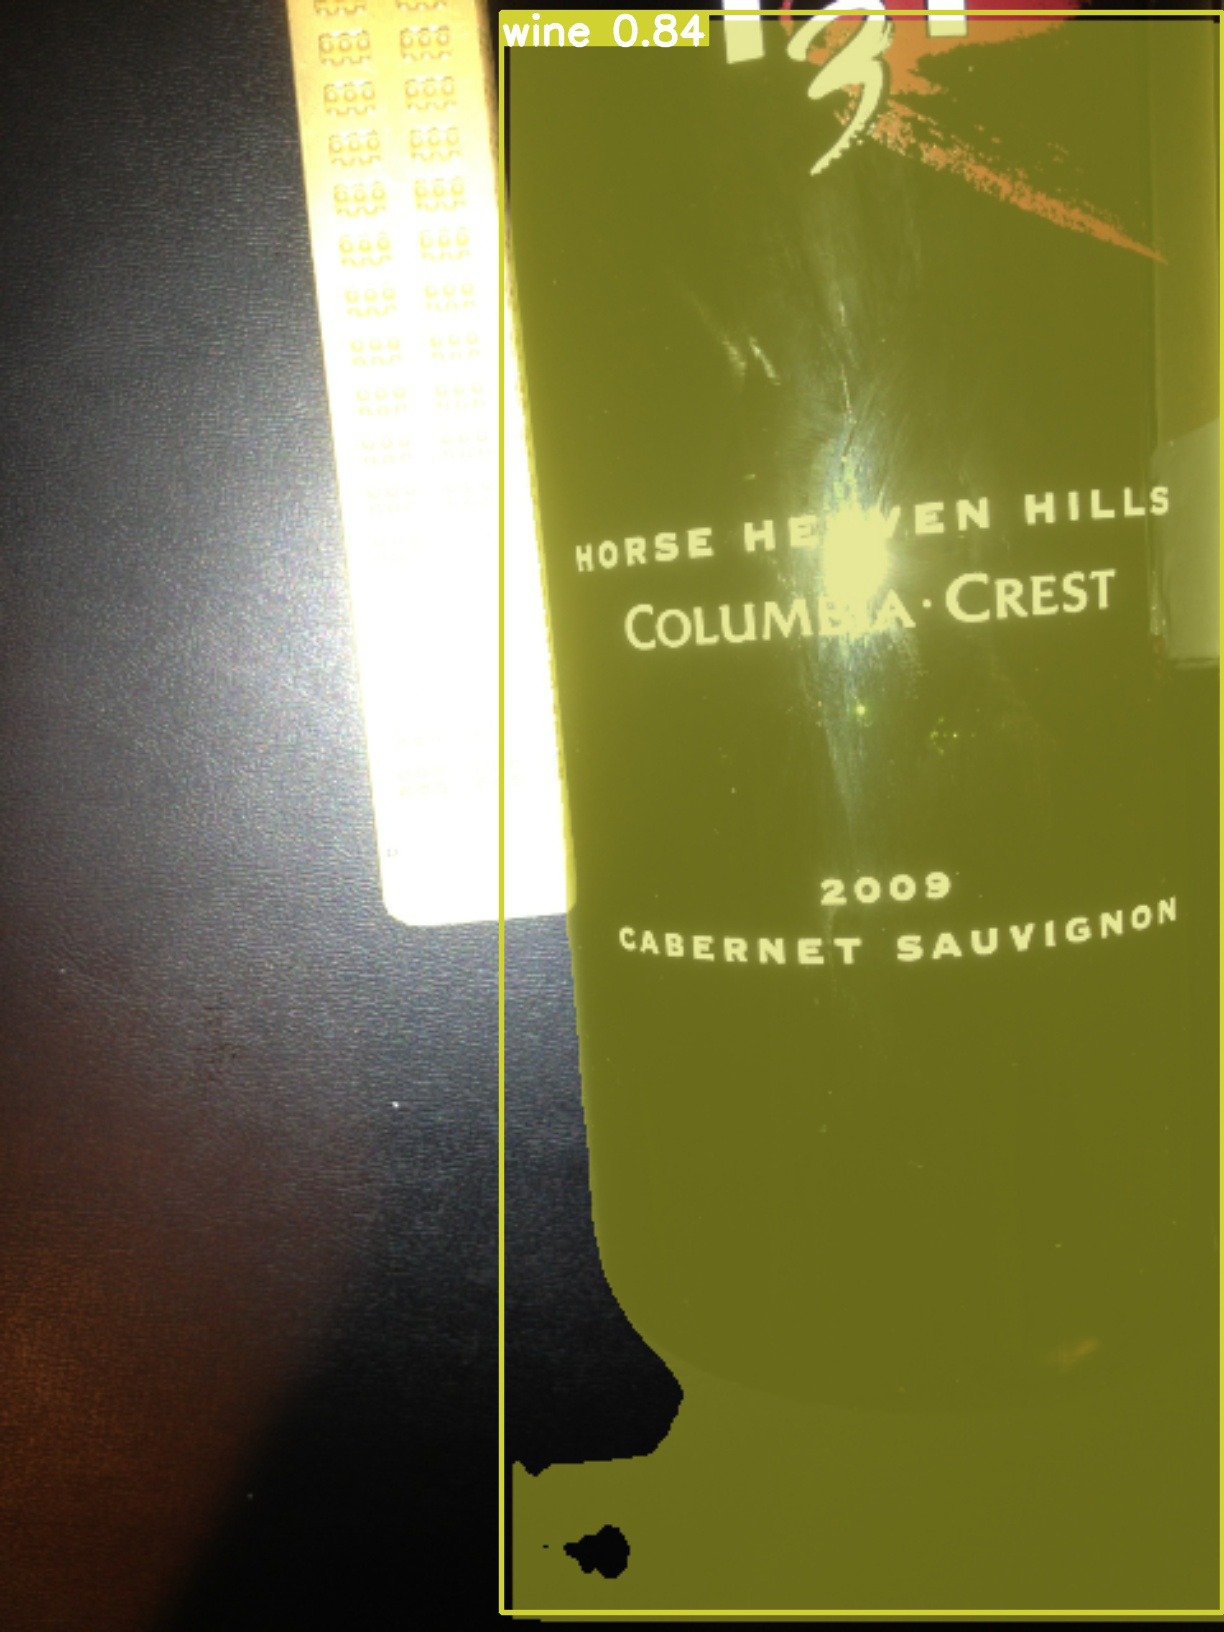

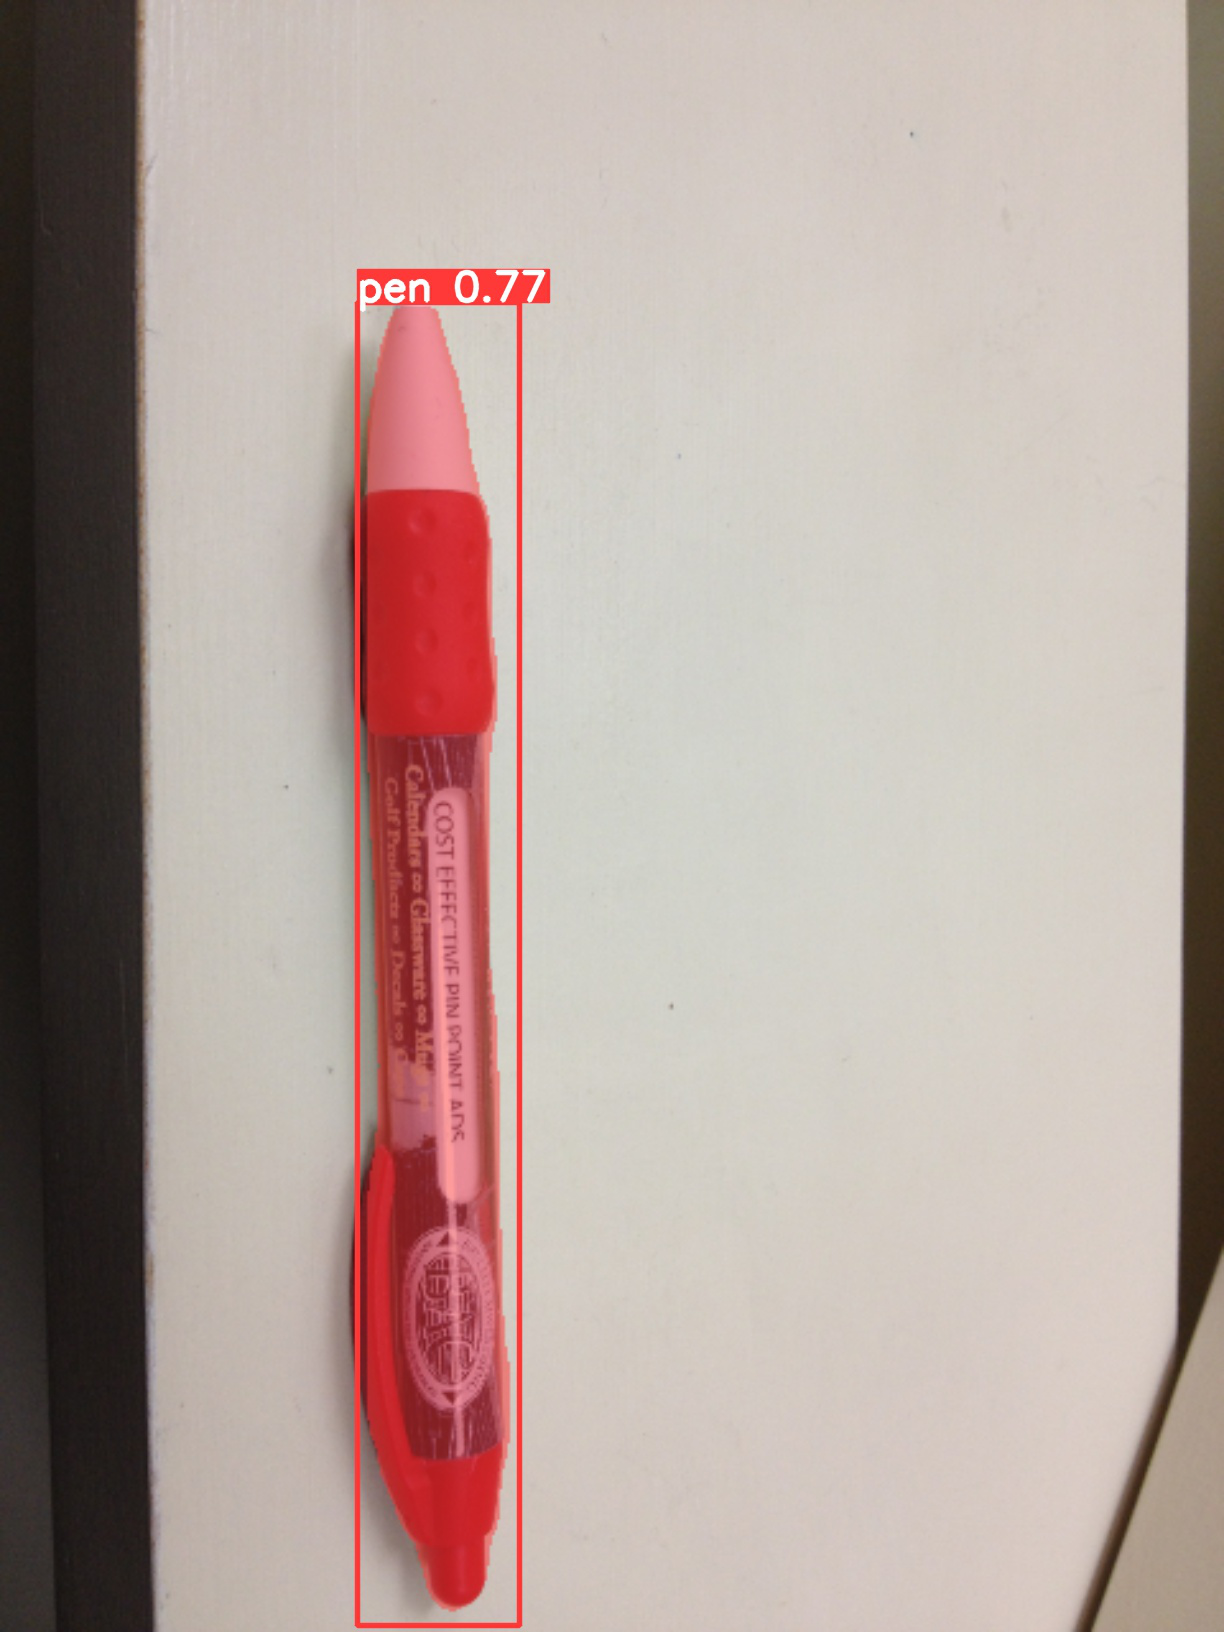

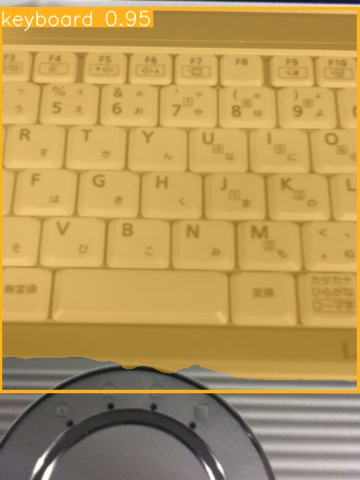

In [7]:
from PIL import Image
from ultralytics import YOLO

model = YOLO('./runs/segment/yolov8-seg.pt25/weights/best.pt')

# Load a test image
image_filenames = [
    'VizWiz_train_00000128.jpg',
    'VizWiz_train_00000570.jpg',
    'VizWiz_train_00003562.jpg',
]

for i, image_filename in enumerate(image_filenames, start=1):

    image_path = os.path.join('./images/train/', image_filename)
    image = Image.open(image_path)
    # Make predictions and save the image
    model.predict(image_path, save=True, imgsz=640, conf=0.5)


output_directory = './runs/segment/predict5/'
# Iterate through the predicted images in the directory
for filename in os.listdir(output_directory):
    if filename.endswith('.jpg'):
        # Specify the full path of the image
        image_path = os.path.join(output_directory, filename)
        # Open and display the image
        image = Image.open(image_path)
        image.show()